# Folding a model through an instrument response

This tutorial shows how nDspec handles instrument response matrices for multi-dimensional models.

In [1]:
import sys
import os
import gc

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from ndspec.Response import ResponseMatrix

## Load and visualize the instrument response

We will start by loading the NICER rmf from path ```filepath``` by initializing an instance of the class ```ResponseMatrix```. The NICER response is separated in rmf and arf files; the initializer recognizes this and automatically prompts the user to pass an arf file through the ```load_arf method```. If instead the full response is contained in just one file (e.g. for RXTE), the class will recognize this and not prompt the user for an additional arf file. Note that for missions when the option to separate the arf from the rmf is left to the user during reduction (e.g. NuSTAR), the prompt to load the arf may be misleading.

In [2]:
rmfpath = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = os.getcwd()+"/data/nicer-consim135p-teamonly-array50.arf"
nicer_matrix.load_arf(arfpath)

Arf missing, please load it
Arf loaded


We can now visualize the response matrix with the ```plot_response``` method. This creates a 2d plot with either channel or channel bound (in units of keV) on the x axis (using the ````plot_type```` flag), incoming photon energy on the y axis, and logarithm of instrument response on the z axis; darker colors correspond to larger instrument response. We can notice three things. 

First, the peak of the response is on a diagonal line, with channel bound (or channel timtes 100 for NICER) roughly equal to incoming energy at least up to 10 keV or so. For example, an incoming 6 keV photon will generally be recorded around channel 600, whose energy bounds are close to 6 keV. In other words we can roughly map channel to photon energy. This is true for most X-ray observatories; in the case of NICER specifically, the ratio is roughly 1 keV to 100 channels.

Second, the bottom left of the plot where channel bound >> incoming energy is zero, while the top left is not. This means that a) a low energy photon will never be recorded in a high (energy) channel, but b) the opposite can happen. Therefore, while we can map channels to energy, this is only an approximation of how the photons are being recorded by the instrument.

Third, note how the low energy, bottom part of the plot is darker than the top. This is the effect of the NICER effective area, which peaks at 3 keV or so and drops off significantly afterwards.

After plotting the response, we call the Python garbage collector to clean up the memory, as this is something Jupyter can struggle with for large 2d plots.

/home/matteo/Software/nDspec/src/ndspec/Response.py:429: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


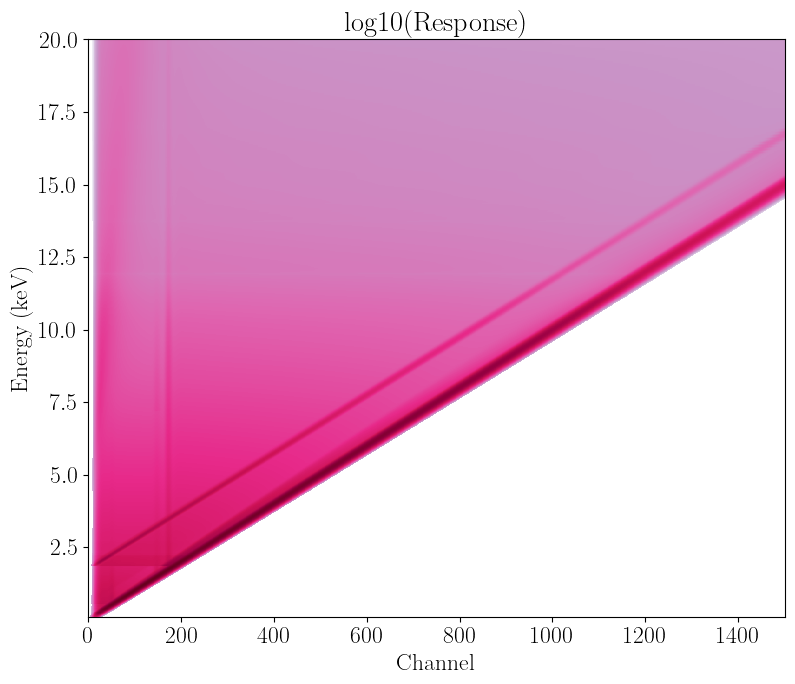

/home/matteo/Software/nDspec/src/ndspec/Response.py:429: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


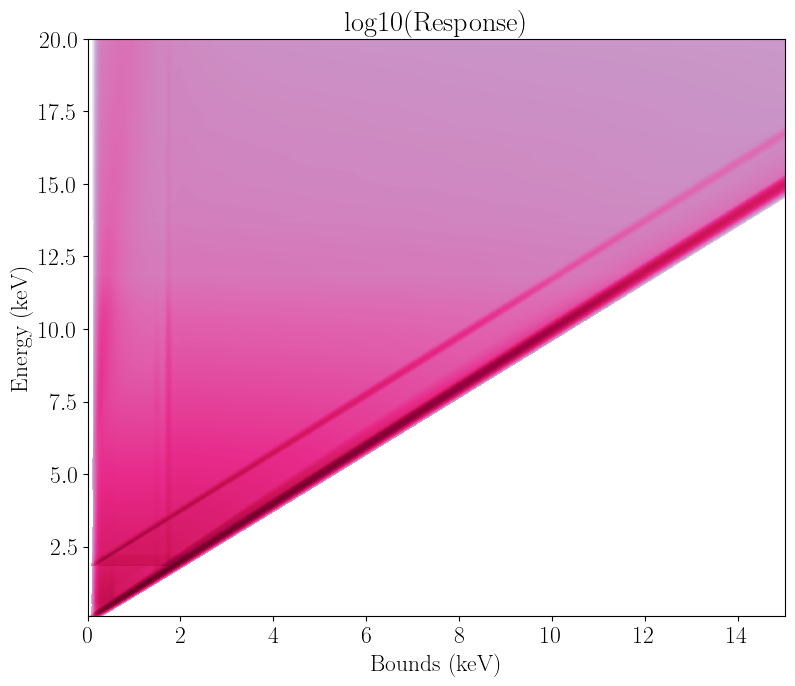

6478

In [3]:
nicer_matrix.plot_response()
nicer_matrix.plot_response(plot_type="energy")

gc.collect()

Similarly, we can visualize the NICER effective area as a function of energy with the ```plot_arf``` method:

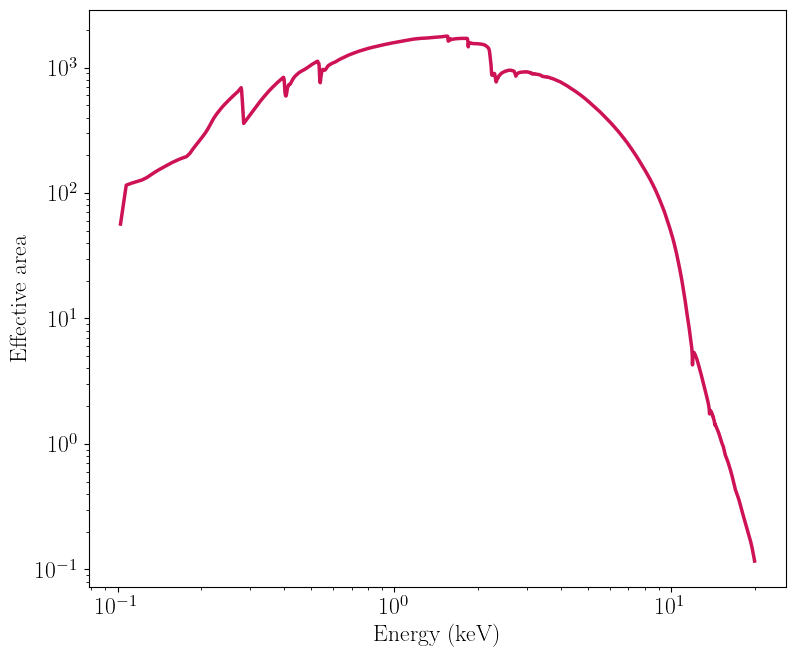

In [4]:
nicer_matrix.plot_arf()

## Define a sample model

Next, let us generate a simple two-dimensional model for a reverberation signal: the impulse response function of a gaussian line that follows a fast rise, exponential decay profile over time, and becomes narrower as it decays. 

This impulse response is defined in "energy space": the model provides photon count rate against time and (incoming) photon energy, i.e., the y-axis in the plots above, but the data we work with is in count rate per channel, ie, the x-axis. 

In [5]:
import numpy as np

#import numpy and define our model functions:
def gaussian(array, params):
    center = params[0]
    width = params[1]
    norm = np.multiply(np.sqrt(2.0*np.pi),width)
    shape = np.exp(-np.power((array - center)/width,2.0)/2)
    line = shape/norm 
    return line

def powerlaw(array, params):
    norm = params[0]
    slope = params[1]
    model = norm*np.power(array,slope)
    return model

def gauss_fred(array1,array2,params):
    times = array1
    energy = array2
    norm = params[0]
    width = params[1]
    center = params[2]
    rise_t = params[3]
    decay_t = params[4]
    decay_w = params[5]
    sigma = width*powerlaw(times,np.array([1.,decay_w]))
    fred_profile = np.exp(np.nan_to_num(-rise_t/times)-np.nan_to_num(times/decay_t))
    fred_pulse = np.zeros((len(energy),len(times)))
    line_profile = np.zeros(len(energy))
    pulse_profile = np.zeros(len(times))
    for i in range(len(times)):
        fred_pulse[:,i] = gaussian(energy,np.array([center,sigma[i]]))*fred_profile[i]    
    line_profile = np.sum(fred_pulse,axis=1)
    pulse_profile = np.sum(fred_pulse,axis=0)
    return fred_pulse, line_profile, pulse_profile

In order to actually compute the model, we need to assume a grid of energies and one of times. For times, let us just take 250 bins between 0.1 and 400 timescales in our putative system (say, the gravitational time t=R\_g/c). 

For the energy grid we have to be more careful, as this needs to be identical to the grid over which the response is binned - the y-axis in the plots above. Therefore, we can get the lower and upper bound of the grid directly from our response files, and then take the arithmetic average in each bin to compute our model. We will assume a centroid line energy of 6 keV, an initial width of 2.5 keV, and rise and decay timescales of 10 and 60 R\_g/c:

In [6]:
#run an interation of our model from the NICER energy array
#this will be a gaussian flash at 6keV
from astropy.io import fits

#read the NICER response to set up an identical energy array
NICER_path = "data/nicer-rmf6s-teamonly-array50.rmf"
NICER_file = fits.open(NICER_path)
# get the extension names needed to find the energy grid
extnames = np.array([h.name for h in NICER_file])
if "MATRIX" in extnames:
    header = NICER_file["MATRIX"]
elif "SPECRESP MATRIX" in extnames:
    header = NICER_file["SPECRESP MATRIX"]
NICER_data = header.data
NICER_energ_lo = np.array(NICER_data.field("ENERG_LO"))
NICER_energ_hi = np.array(NICER_data.field("ENERG_HI"))
NICER_energy_array = (NICER_energ_lo+NICER_energ_hi)/2.
NICER_energy_channels=len(NICER_energy_array)
NICER_file.close()

#define a time grid and evaulaute the model defined earlier
time_res = 250
time_array = np.linspace(0.1,400,time_res)

impulse_test, line_profile, pulse_profile = gauss_fred(time_array,NICER_energy_array,[1.,2.5,6.0,10,60,-0.25])

## Visualize the model

Now let us make a similar 2d plot as above to visualize our model. We can also project the model in either the time direction (to obtain the time-averaged spectrum) or in the energy direction (to obtain the lightcurve):

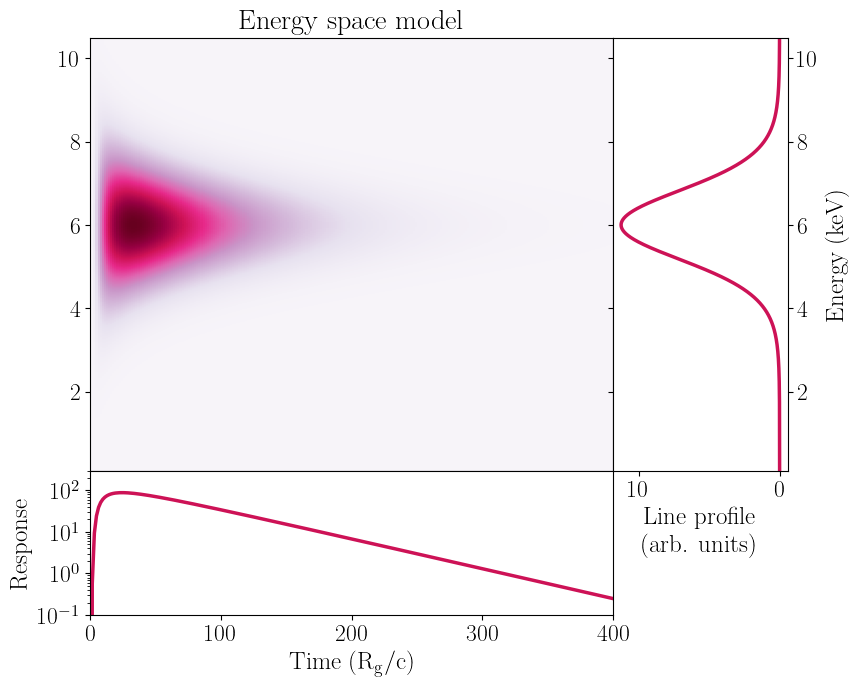

12024

In [7]:
#plot our model:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

colorscale = pl.cm.PuRd(np.linspace(0.,1.,5))

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

ax.pcolormesh(time_array,NICER_energy_array,impulse_test,cmap="PuRd",
          shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-1,3e2])
below.set_xlim([0,400])

side.plot(line_profile,NICER_energy_array,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylabel("Energy (keV)",fontsize=18)
side.set_ylim([0.1,10.5])

ax.set_title("Energy space model")

plt.show()

gc.collect()

## Convolve the model with the instrument response

We can now obtain a "detector space" model by convolving the instrument response we have loaded with the model we have calculated with the ```convolve_response``` method. Note that because our response is in matrix form, formally what we are computing is a matrix multiplication, rather than a convolution.

Regardless, it is this convolved model that is appropriate for comparison with the data. Note that if we could map photon energy to channels this step could be avoided - mathematically, this corresponds to a diagonal response matrix, with elements equal to only 0 or 1. This is typically the case for lower wavelength (e.g optical or infrared) data, and is nominally supported in nDspec through the ````diagonal_matrix```` method of a ````ResponseMatrix```` object.

In [8]:
convolved_model = nicer_matrix.convolve_response(impulse_test)

Let us plot our model again, but this time in "detector space" after the convolution. Again, we can note two important things.

First, the peak of the line is at channels < 600, even though the Gaussian centroid we provided is at 6 keV and for NICER we expect channels to roughly map 1:100 to photon energies. This is because, as we discussed earlier, the telescope effective area drops as energy increases. Therefore, the model normalization at channel 600 will be lower than, say, at channel 550. 

Second, some small features that appear between channels 100 and 250. These are prooduce by instrumental features in the redistribution matrix and effective area.

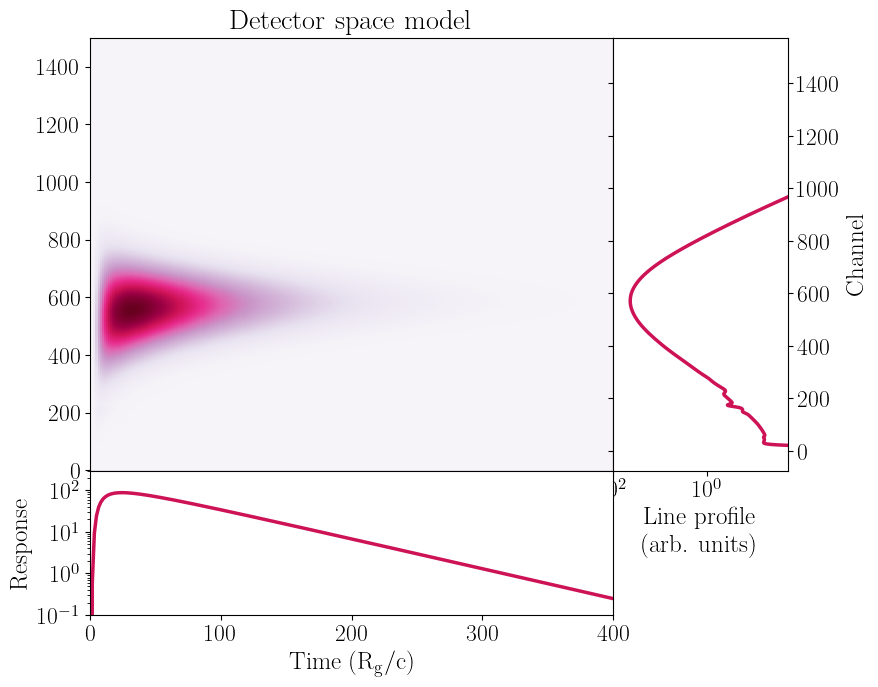

11722

In [9]:
#plot the model again to visualize it:
convolved_line_profile = np.zeros(nicer_matrix.n_chans)

for i in range(time_res):
    for j in range(nicer_matrix.n_chans):
        convolved_line_profile[j] = convolved_line_profile[j] + convolved_model[j][i]

colorscale = pl.cm.PuRd(np.linspace(0.,1.,5))

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

ax.pcolormesh(time_array,nicer_matrix.chans,convolved_model,cmap="PuRd",
              shading='auto',linewidth=0,rasterized=True)

ax.set_xticklabels([])
ax.set_xlim([0,400.])
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_xlim([0,400.])
below.set_ylim([1e-1,3e2])

side.plot(convolved_line_profile,nicer_matrix.chans,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylabel("Channel",fontsize=18)
side.set_xscale("log")
side.set_xlim([1e2,2e-2])

ax.set_title("Detector space model")

plt.show()

gc.collect()

## Benchmark the convolution:

The steps above have one issue: the run-time of our convolution is on the order of tens of milliseconds on a typical laptop:

In [10]:
from timeit import Timer

%timeit nicer_matrix.convolve_response(impulse_test)

19.5 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Rebin the instrument response

The computation time above may not seems slow at a glance, but in practice it is not too far off the time to compute a typical phenomenological Xspec model, or even slower. Additionally, dealing with higher dimensionality data (such as spectral imaging, or combinbing spectral, timing and polarimetric data) will further increase runtime drastically. This means that accounting for the instrument response is a major bottleneck in fitting modern, multi-dimensional data.

Luckily, we do not actually need 1500 channels when it comes to most X-ray data. For instance, typical NICER timing products like lag spectra only use a few dozen energy bins, meaning we can rebin our instrument response to a grid of a few dozen channels instead. 

Let us define some arbitrary new grid of energies from 0.1 to 10 keV. We can then rebin our matrix object with the ```rebin_response``` method to this new, smaller grid made up of only 35 channels. After doing so, let us plot the response again, comparing channel and bounds once again:

/home/matteo/Software/nDspec/src/ndspec/Response.py:429: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


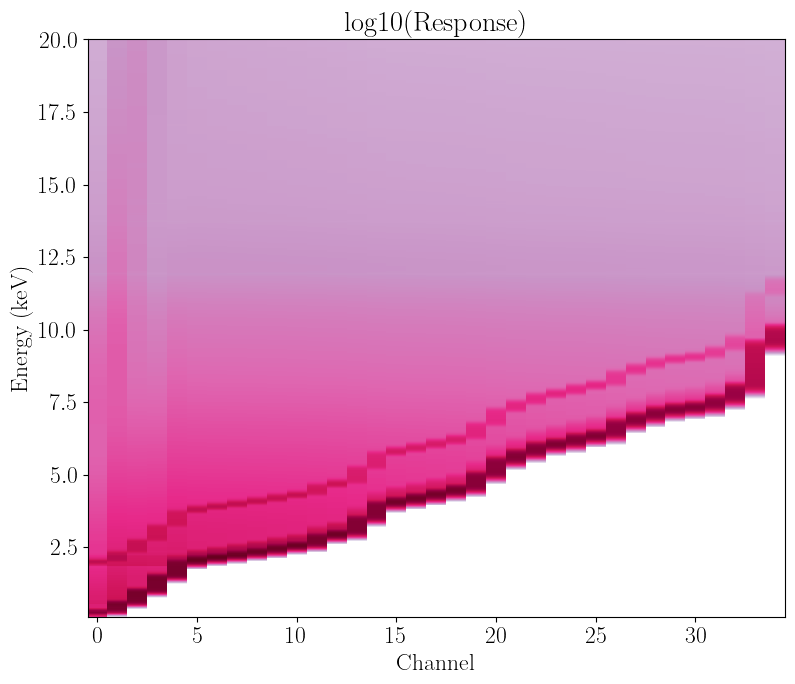

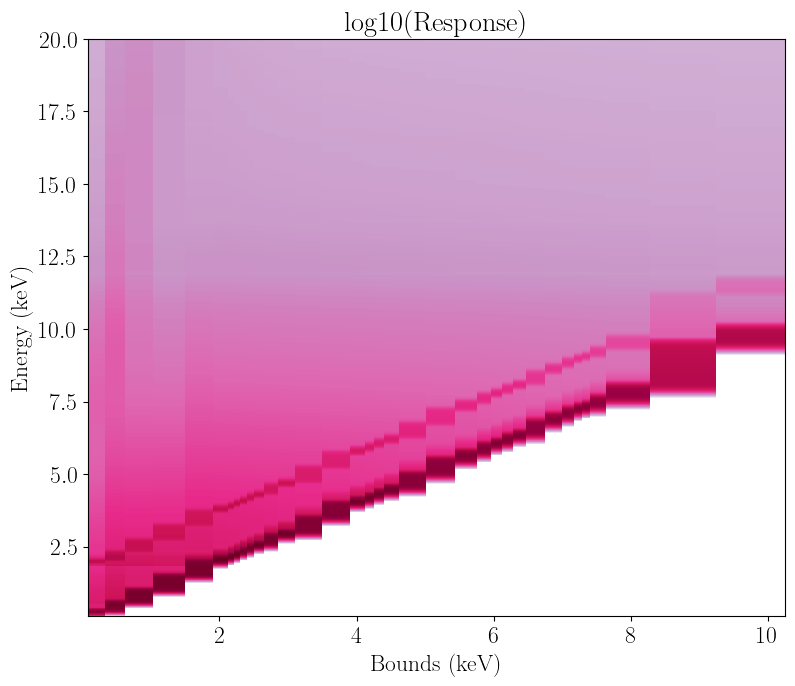

6222

In [11]:
#define an arbitrary grid, from arrays of lower and upper energy bounds
new_bounds_lo = np.array([0.1,0.3,0.6,1,1.5,2,2.13,2.21,2.3,2.4,2.52,2.6,2.9,3.,3.5,4.,4.12,4.25,
                          4.4,4.54,5,5.5,5.75,6,6.1,6.3,6.4,6.8,7,7.2,7.3,7.35,7.6,8,9.5])
new_bounds_hi = np.array([0.3,0.6,1,1.5,2,2.13,2.21,2.3,2.4,2.52,2.6,2.9,3.,3.5,4.,4.12,4.25,4.4,
                          4.54,5,5.5,5.75,6,6.1,6.3,6.4,6.8,7,7.2,7.3,7.35,7.6,8,9.5,10.])

#rebin the response matrix and plot the resulting new matrix
rebin_matrix = nicer_matrix.rebin_response(new_bounds_lo,new_bounds_hi)
rebin_matrix.plot_response()
rebin_matrix.plot_response(plot_type="energy")

gc.collect()

Note that the response is much coarser, as we would expect, but for spectral-timing data this is not a problem. We can now convolve this new matrix with our impulse response model:

In [12]:
rebinned_model = rebin_matrix.convolve_response(impulse_test)

## Visualize the re-binned, convolved model

Let us plot our convolved model once again, but this time against the 35 arbitrarily spaced, channels  defined above instead of the usual 1500. Note how the channel dependence has re-shaped our model, and the line profile only vaguely resembles a Gaussian profile. This is because our Gaussian is defined in energy space, and (unlike the native NICER binning) in our new grid the 35 channels do not have uniform spacing in energy:

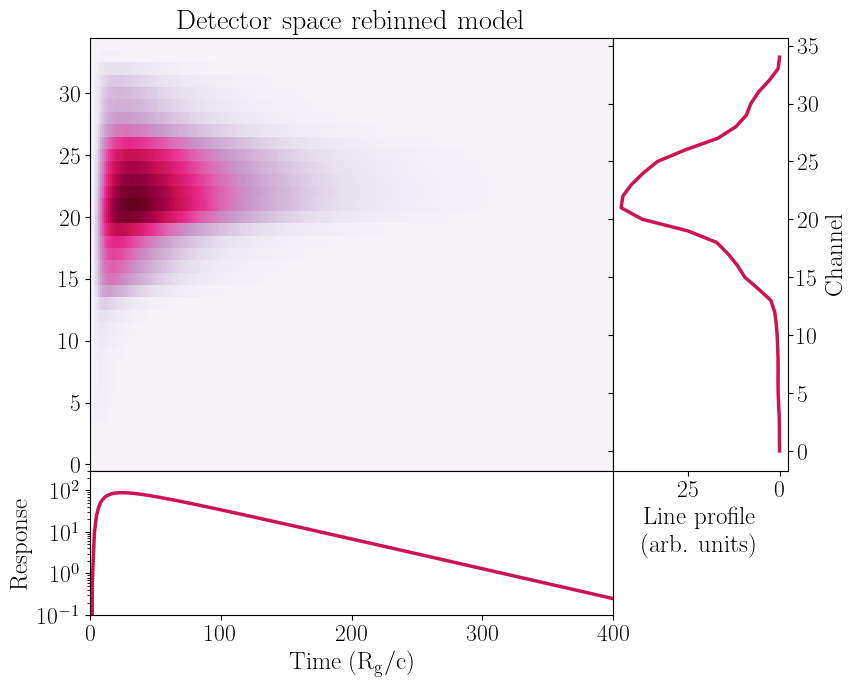

12284

In [13]:
rebinned_line_profile = np.zeros(rebin_matrix.n_chans)

new_bounds = 0.5*(rebin_matrix.emax+rebin_matrix.emin)

#because we rebinned the response, we need to re-calculate the line profile
for j in range(rebin_matrix.n_chans):
    rebinned_line_profile[j] = np.sum(rebinned_model[j,:])

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

ax.pcolormesh(time_array,rebin_matrix.chans,rebinned_model,cmap="PuRd",
              shading='auto',linewidth=0,rasterized=True)

ax.set_xticklabels([])
ax.set_xlim([0,400.])
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_xlim([0,400.])
below.set_ylim([1e-1,3e2])

side.plot(rebinned_line_profile,rebin_matrix.chans,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylabel("Channel",fontsize=18)

ax.set_title("Detector space rebinned model")

plt.show()

gc.collect()

All this means is that converting from channel to energy (and vice versa) is no longer straighfroward. However, this is handled automatically by ```rebin_response```, which also adjusts the energy arrays stored in our ResponseMatrix object. 

We can take the newly defined energy bins defined above, and plot against these instead of channel number, to recover a more ''reasonable'' looking impulse response function. With these units, we see the same behavior as the full response earlier: the drop in effective area at high energy causes resultant shift of the peak of the line to below 5 keV, while the minor features at low channels have been smeared out and are even less noticeable:

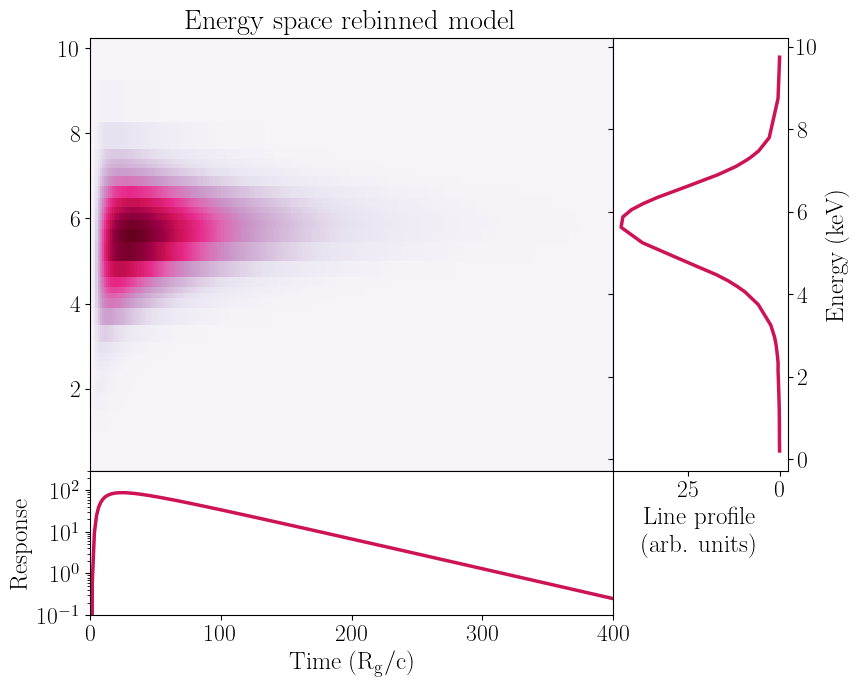

12134

In [14]:
fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

ax.pcolormesh(time_array,new_bounds,rebinned_model,cmap="PuRd",
              shading='auto',linewidth=0,rasterized=True)

ax.set_xticklabels([])
ax.set_xlim([0,400.])
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_xlim([0,400.])
below.set_ylim([1e-1,3e2])

side.plot(rebinned_line_profile,new_bounds,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylabel("Energy (keV)",fontsize=18)

ax.set_title("Energy space rebinned model")

plt.show()

gc.collect()

And if we benchmark the convolution with the coarser response, we find that this operation is now far, far faster:

In [15]:
%timeit rebin_matrix.convolve_response(impulse_test)

1.48 ms ± 69.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


And we are down to about 1ms, a factor of 10 or more without any additional optimization such as just-in-time compilation and GPU acceleration!